## Value-at-Risk: Using Historical Simulation

**Functions**

`Series.quantile`, `Series.rolling`

### Exercise 81
Compute the 1-, 5- and 10-day historical simulation VaR for the S&P 500 and
the EUR/USD rate.

**Note**: Start the historical simulation at 25% of the data, and then build the
additional forecasts using a recursive scheme.

Let's begin by importing the data:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

In [2]:
sp500 = pd.read_hdf("./data/arch-data.h5", "sp500")
eurusd = pd.read_hdf("./data/arch-data.h5", "eurusd")

Creating returns (as log diff rather than pct changes for time easier time aggregation):

In [3]:
sp500_returns = 100 * np.log(sp500.SP500).diff().dropna()
eurusd_returns = 100 * np.log(eurusd.DEXUSEU).diff().dropna()

We will use pandas `expanding` method to find the 5th quantile and hence the VaR at 95%. The documentation can be found here: [expanding Doc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.expanding.html)

As we can see `expanding` is similar to `rolling`, but with a fixed starting point. The key parameter is `min_periods`
which sets the smallest sample that will be used.  A key feature of `expanding`
is that the statistic computed using observations $0$, $1$, $\ldots$, $m$ are
placed in position $m$. In code notation, `stat[m] = func(data[:(m+1)])`.  This
is important when forecasting since the value in position $m$ is the forecast
for `m+1`. We could use `shift` to move it forward 1 observation, which aligns the
forecast with its realization.

Before we start, we need to find the 25% of the data after which we can start our historical simulations.

In [5]:
start = int(sp500_returns.shape[0] * 0.25)

Let's begin with the 1-day historical simulation for the VaR:

In [6]:
# Expanding historical quantile
var_5_1day = -sp500_returns.expanding(min_periods=start).quantile(0.05)
var_5_1day

DATE
2011-02-15         NaN
2011-02-16         NaN
2011-02-17         NaN
2011-02-18         NaN
2011-02-22         NaN
                ...   
2019-12-24    1.514036
2019-12-26    1.513876
2019-12-27    1.513716
2019-12-30    1.513556
2019-12-31    1.513396
Name: SP500, Length: 2234, dtype: float64

To implement HS over longer horizons, we first need to compute the $h$-day return.
We construct the returns using `rolling(h).sum()`. Finally, we can use `expanding`
on the 5-day returns to compute the expanding set of quantiles. Again, these are
aligned at the point where the forecast is made, not where it is forecasting.

In [7]:
# Calculating 5-day return
rets_5_day = sp500_returns.rolling(5).sum().dropna()
# Expanding historical quantile
var_5_5day = -rets_5_day.expanding(min_periods=start).quantile(0.05)
var_5_5day

DATE
2011-02-22         NaN
2011-02-23         NaN
2011-02-24         NaN
2011-02-25         NaN
2011-02-28         NaN
                ...   
2019-12-24    3.086164
2019-12-26    3.085018
2019-12-27    3.083871
2019-12-30    3.082724
2019-12-31    3.081577
Name: SP500, Length: 2230, dtype: float64

In [8]:
# Calculating 10-day return
rets_10_day = sp500_returns.rolling(10).sum().dropna()
# Expanding historical quantile
var_5_10day = -rets_10_day.expanding(min_periods=start).quantile(0.05)
var_5_10day

DATE
2011-03-01         NaN
2011-03-02         NaN
2011-03-03         NaN
2011-03-04         NaN
2011-03-07         NaN
                ...   
2019-12-24    4.111978
2019-12-26    4.111762
2019-12-27    4.111546
2019-12-30    4.111330
2019-12-31    4.111114
Name: SP500, Length: 2225, dtype: float64

We next join the series in one dataframe and plot them.

In [9]:
# Importing plot packages
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# Setting plot info
sns.set_style("darkgrid")
plt.rc("figure",figsize=(16,6))
plt.rc("font",size=14)

In [11]:
# Concatenating the data in one DataFrame
value_at_risks = pd.concat([var_5_1day, var_5_5day, var_5_10day], axis=1)
value_at_risks = value_at_risks.dropna(how="all")
value_at_risks.columns = ["1-day 5% VaR","5-day 5% VaR","10-day 5% VaR"]

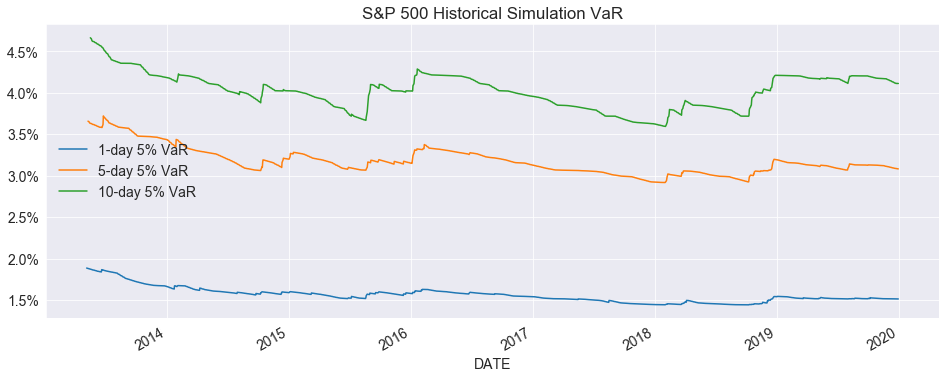

In [12]:
# Plotting the DataFame
ax = value_at_risks.plot(legend=False)
ax.set_yticklabels([f"{tick}%" for tick in ax.get_yticks()])
ax.set_title("S&P 500 Historical Simulation VaR")
lgd = plt.legend(frameon=False)

Doing the same analysis at once for the EUR/USD exchange rate. To do so, we will loop over the return horizon.

In [13]:
# Looping over return horizon
eurusd_value_at_risks = {}
for horizon in (1,5,10):
    # Calculating multi day return
    multi_day_returns = eurusd_returns.rolling(horizon).sum().dropna()
    # Getting VaR
    actual_var = multi_day_returns.expanding(min_periods=start).quantile(0.05)
    # Negate to make sure the VaR is positive
    eurusd_value_at_risks[f"{horizon}-day 5% VaR"] = -actual_var
# Joinig all in a dataframe
eurusd_value_at_risks = pd.DataFrame(eurusd_value_at_risks).dropna(how="all")

Plotting the VaRs for the EUR/USD exchange rate:

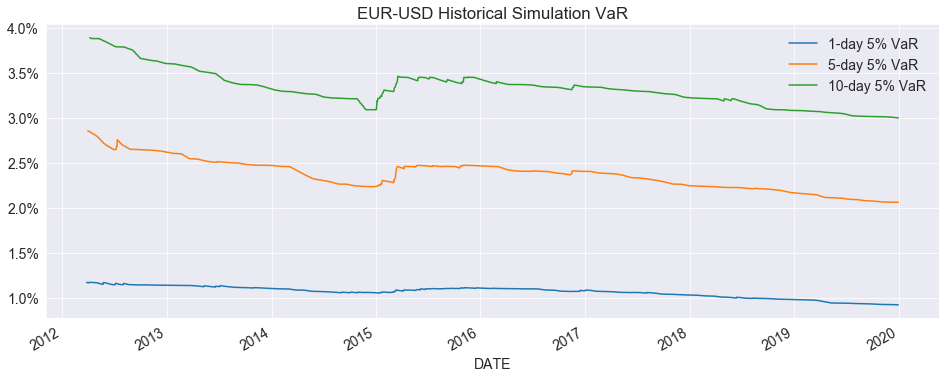

In [14]:
# Doing the plot with the same properties of the one above
ax = eurusd_value_at_risks.plot(legend=False)
ax.set_yticklabels([f"{tick}%" for tick in ax.get_yticks()])
ax.set_title("EUR-USD Historical Simulation VaR")
plt.legend(frameon=False)

Finally, we can save the data for later use. 

In [15]:
with pd.HDFStore("./data/hs-var.h5", mode="w") as hdf:
    hdf.put("sp500_var", value_at_risks)
    hdf.put("eurusd_var", eurusd_value_at_risks)